## Isomap2 is based on Isomap from scikit learn, which the code is modified so it can take distance matrix as the input.
### Different distance measures and surface properties is going to be examined here, see v3 for detial of the calculation

In [1]:
import pandas as pd
import numpy as np
import scipy
import fnmatch

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

from sklearn.decomposition import PCA, KernelPCA
from sklearn import manifold
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors

import os
import re
import numpy.linalg
# import ot

from itertools import combinations, product
import networkx as nx
import dionysus as dos
import pickle
import sys
import copy

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

%matplotlib inline
# %matplotlib notebook
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

# import cxs_pars_func
import sys
sys.path.append('./../')
from cxs_pars_func import *

In [2]:
from sklearn.manifold.isomap2 import Isomap2
from sklearn.metrics.pairwise import euclidean_distances
import scipy.spatial.distance as scpydist
from sklearn import neighbors
from scipy.sparse import csgraph
from scipy import stats

In [3]:
file_base = './../cxs_med/'
basename = './../cxs_med/'
with open('./../cxs_list.pkl', 'rb') as fp:
    cxs_list = pickle.load(fp)
csd_mof = pd.read_excel('./../CSD_MOFs.xlsx', index_col=0)

## Select surface property and distance type

In [4]:
surf_ppt_sel = 0
surf_ppt = ['d_e', 'curvedness', 'shape_idx', 'd_i']
grp_lpl_sel = 0
grp_lpl_ppt = ['d_e', 'curvedness', 'shape_idx', 'd_i']
bcd_dist_sel = 1
bcd_dist = ['wsstq2', 'btlnk']

## Load distance matrix

In [5]:
# btl_dis
# with open('./btlnk_493med_'+surf_ppt[surf_ppt_sel]+'.plk', 'rb') as fp:
with open('./../'+bcd_dist[bcd_dist_sel]+'_493med_'+surf_ppt[surf_ppt_sel]+'.plk', 'rb') as fp:
    btlnk_ld = pickle.load(fp)
    
# Replace inf with NaN so it can be discarded by Pandas
btlnk_ld = btlnk_ld.replace([np.inf, -np.inf], np.nan, inplace=False)
# The loaded distance data is a distance matrix, only upper has the non-zero entries,
# so NaN can be discarded.
btlnk_ld.dropna(axis=1, inplace=True)
# ind_len = len(btlnk_ld.loc[btlnk_ld.iloc[:,0].dropna().index.tolist(), btlnk_ld.iloc[:,0].dropna().index.tolist()])
ind_len = len(btlnk_ld.index)
i_lower = np.tril_indices(ind_len, -1)

## make the distance matrix symmetric

In [6]:
btlnk_arr = btlnk_ld.values
btlnk_arr[i_lower] = btlnk_arr.T[i_lower]

## plot residual variance of isomap vs number of neighbors, number of connected componentes will be checked

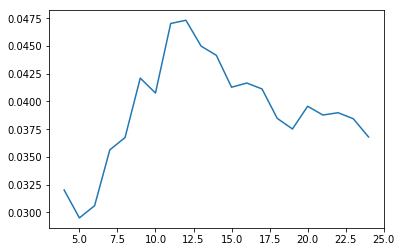

In [8]:
res_var = []
nnb_arr = []
for nnb in range(3,25):
    adj = neighbors.kneighbors_graph(btlnk_arr, n_neighbors=nnb, metric='precomputed')
    n_components, labels = csgraph.connected_components(adj, directed=False)
    if n_components == 1:
        nnb_arr.append(nnb)
        manilern_tmp = Isomap2(n_neighbors=nnb,n_components=3,)
        prj_unfld_tmp = manilern_tmp.fit_transform(btlnk_arr)
        res_var.append(\
                      1- scipy.stats.pearsonr(manilern_tmp.dist_matrix_.flatten(),
                        scipy.spatial.distance.cdist(prj_unfld_tmp, prj_unfld_tmp).flatten())[0]**2)
plt.plot(nnb_arr, res_var)

In [7]:
iso2nnb = 5
manilern = Isomap2(n_neighbors=iso2nnb,n_components=3,
#                       neighbors_algorithm='kd_tree',
                     )
# manilern = manifold.Isomap(n_neighbors=3,n_components=2,neighbors_algorithm='kd_tree')
prj_unfld = manilern.fit_transform(btlnk_arr)

[MoviePy] >>>> Building video btlnk_isomap_alt10d_e.mp4
[MoviePy] Writing video btlnk_isomap_alt10d_e.mp4


100%|█████████▉| 500/501 [00:41<00:00, 11.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: btlnk_isomap_alt10d_e.mp4 



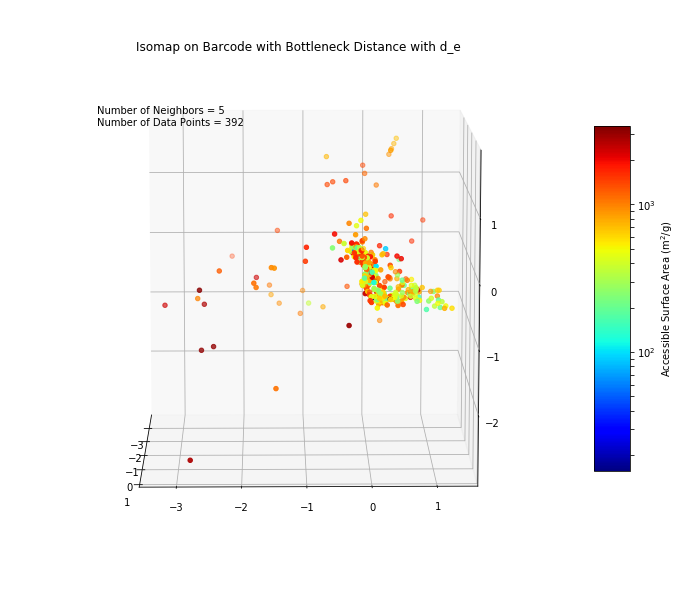

In [12]:
duration = 10
cpd_c = 0
clrmp = mpl.cm.get_cmap('jet')

fig1 = plt.figure(figsize=(10,8))
# ax1 = fig1.add_subplot(111, projection='3d',)
ax1 = fig1.add_axes([0,0,.8,1], projection='3d')
ax1cb = fig1.add_axes([.81,0.2,.05,.6])

clrr = []
chem_fml = []
# for cpdn in wsds_ld.iloc[:,0].dropna().index.tolist():
for cpdn in btlnk_ld.iloc[:,0].dropna().index.tolist():
#     clrr.append(csd_mof.loc[cpdn][6])
    clrr.append(csd_mof.loc[cpdn][7])
    chem_fml.append(csd_mof.loc[cpdn][0])
clrnorm = mpl.colors.LogNorm(min(clrr), max(clrr))
# ax1.w_zaxis.line.set_lw(0.)
# ax1.w_zaxis.set_pane_color((1,1,1,0))
# # ax1.w_zaxis.grid(False)
# # ax1.set_zticks([])
# ax1.set_zticklabels([])
# for t in ax1.zaxis.get_major_ticks():
#     t.label.set_fontsize(10)
#     t.tick1line.set_alpha(0)
cpd_c = 0

# ax1.scatter(*prj_unfld610.T[0:3], c=clrmp(clrnorm(clrr)))
# ax1.scatter(*prj_unfld.T[0:3], c=clrmp(clrnorm(clrr)))
ax1.scatter(prj_unfld.T[0], prj_unfld.T[1], prj_unfld.T[2], 
            c=clrmp(clrnorm(clrr)),
           )
ax1.text2D(0.15, 0.8, 'Number of Neighbors = 5\nNumber of Data Points = 392', 
           transform=ax1.transAxes)
# ax1.set_title('Isomap on Barcode with Bottleneck Distance with '+surf_ppt[surf_ppt_sel]+'/'+grp_lpl_ppt[grp_lpl_sel] )
# ax1.set_title('Isomap on Barcode with Bottleneck Distance with '+surf_ppt[surf_ppt_sel]+'*'+grp_lpl_ppt[grp_lpl_sel] )
ax1.set_title('Isomap on Barcode with Bottleneck Distance with '+surf_ppt[surf_ppt_sel])
# ax1.set_title('Isomap on Barcode with 2-Wasserstein Distance with '+surf_ppt[surf_ppt_sel]+'*'+grp_lpl_ppt[grp_lpl_sel] )
# ax1.set_title('Isomap on Barcode with 2-Wasserstein Distance with '+surf_ppt[surf_ppt_sel]+'/'+grp_lpl_ppt[grp_lpl_sel] )
cb1 = mpl.colorbar.ColorbarBase(ax1cb, cmap=clrmp,
                                norm=clrnorm,
                                orientation='vertical')
cb1.set_label('Accessible Surface Area (m$^2$/g)')
ax1.view_init(10,30)
fig1.tight_layout()
def make_frame(t:float):
    ax1.view_init(10, t/duration * 360)
    fig1.tight_layout()
    return mplfig_to_npimage(fig1)
# fig1.savefig('./figs_final/iso508_nb6_g', dpi=400, bbox_inches='tight')
# fig1.savefig('./figs_final/iso508_nb6_g.pdf', bbox_inches='tight')
animation = VideoClip(make_frame, duration=duration)
# animation.write_videofile('btlnk_isomap_alt'+str(10)+'dvcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile('btlnk_isomap_alt'+str(10)+'mtcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile('wsstq2_isomap_alt'+str(10)+'mtcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile('wsstq2_isomap_alt'+str(10)+'dvcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile('wsstq2_isomap_alt'+str(10)+'dvcb'+surf_ppt[surf_ppt_sel]+'.mp4', fps=50)
animation.write_videofile(bcd_dist[bcd_dist_sel]+'_isomap_alt'+str(10)+surf_ppt[surf_ppt_sel]+'.mp4', fps=50)

## minimum distance to neighbors

In [12]:
min_dist_avg = []
for all_dist in manilern.dist_matrix_:
#     min_dist.append(min(all_dist[np.nonzero(all_dist)]))
    all_dist.sort()
    min_dist_avg.append(np.average(all_dist[1:iso2nnb+1]))

## kernel density estimation for minimum distance to neighbors

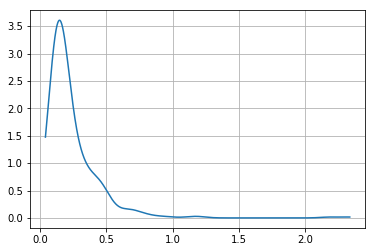

In [13]:
krnl = stats.gaussian_kde(min_dist_avg)
plt.plot(np.arange(min(min_dist_avg), max(min_dist_avg), .001), 
         krnl(np.arange(min(min_dist_avg), max(min_dist_avg), .001)))
ax_t = plt.gca()
ax_t.grid()

## select MOF's from the distribution, low-tial, hi-tail and peak

In [63]:
n_smp_prt = 10
# min_dist_avg.sort()
lo_tail = np.argsort(min_dist_avg)[:n_smp_prt]
hi_tail = np.argsort(min_dist_avg)[-n_smp_prt:]

arg_pk = np.arange(min(min_dist_avg), max(min_dist_avg), .001)[\
np.argmax(krnl(np.arange(min(min_dist_avg), max(min_dist_avg), .001)))]
pk_rgn = np.argsort(np.abs(min_dist_avg - arg_pk))[:n_smp_prt]

In [64]:
btlnk_ld.columns.values[lo_tail.tolist()]
# lo_tail.tolist()

array(['CAYDOX01', 'CAYDOX04', 'CAYDOX02', 'CAYDOX03', 'CAYDOX',
       'CAYDOX06', 'CAYGIU', 'CAYDOX05', 'FURRAM', 'FUSMEM'], dtype=object)

## Kernel density estimation for isomap low-dim embedding, subsetting low and high density points

In [10]:
krnl = stats.gaussian_kde(prj_unfld.T)

[MoviePy] >>>> Building video btlnk_isomap_alt10d_e_dsty.mp4
[MoviePy] Writing video btlnk_isomap_alt10d_e_dsty.mp4


100%|█████████▉| 400/401 [00:21<00:00, 18.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: btlnk_isomap_alt10d_e_dsty.mp4 



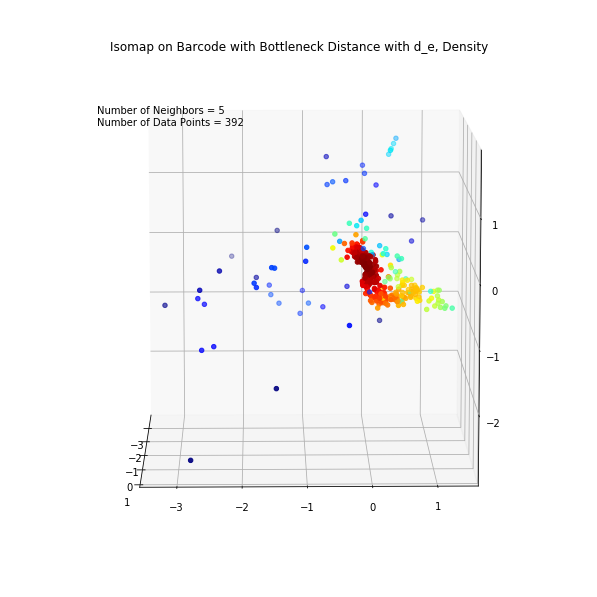

In [30]:
duration = 8
cpd_c = 0
clrmp = mpl.cm.get_cmap('jet')

clrr = []
for ptpos in prj_unfld:
    clrr.append(krnl(ptpos)[0])
clrnorm = mpl.colors.LogNorm(min(clrr), max(clrr))

fig1 = plt.figure(figsize=(10,8))
# ax1 = fig1.add_subplot(111, projection='3d',)
ax1 = fig1.add_axes([0,0,.8,1], projection='3d')
# ax1cb = fig1.add_axes([.81,0.2,.05,.6])

cpd_c = 0
ax1.scatter(*prj_unfld.T, c=clrmp(clrnorm(clrr)))

ax1.text2D(0.15, 0.8, 'Number of Neighbors = 5\nNumber of Data Points = 392', 
           transform=ax1.transAxes)
ax1.set_title('Isomap on Barcode with Bottleneck Distance with '+surf_ppt[surf_ppt_sel]+', Density')
# ax1.set_title('Isomap on Barcode with Bottleneck Distance with '+surf_ppt[surf_ppt_sel]+'/'+grp_lpl_ppt[grp_lpl_sel] )
# ax1.set_title('Isomap on Barcode with Bottleneck Distance with '+surf_ppt[surf_ppt_sel]+'*'+grp_lpl_ppt[grp_lpl_sel] )
# ax1.set_title('Isomap on Barcode with 2-Wasserstein Distance with '+surf_ppt[surf_ppt_sel]+'*'+grp_lpl_ppt[grp_lpl_sel] )
# ax1.set_title('Isomap on Barcode with 2-Wasserstein Distance with '+surf_ppt[surf_ppt_sel]+'/'+grp_lpl_ppt[grp_lpl_sel] )

ax1.view_init(10,70)
fig1.tight_layout()
def make_frame(t:float):
    ax1.view_init(10, t/duration * 360)
    fig1.tight_layout()
    return mplfig_to_npimage(fig1)
# fig1.savefig('./figs_final/iso508_nb6_g', dpi=400, bbox_inches='tight')
# fig1.savefig('./figs_final/iso508_nb6_g.pdf', bbox_inches='tight')
animation = VideoClip(make_frame, duration=duration)
# animation.write_videofile('btlnk_isomap_alt'+str(10)+'dvcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile('btlnk_isomap_alt'+str(10)+'mtcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile('wsstq2_isomap_alt'+str(10)+'mtcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile('wsstq2_isomap_alt'+str(10)+'dvcb'+surf_ppt[surf_ppt_sel]+grp_lpl_ppt[grp_lpl_sel]+'.mp4', fps=50)
# animation.write_videofile(bcd_dist[bcd_dist_sel]+'_isomap_alt'+str(10)+surf_ppt[surf_ppt_sel]+'hilite.mp4', fps=50)
# animation.write_videofile('test1.mp4', fps=50)
animation.write_videofile(bcd_dist[bcd_dist_sel]+'_isomap_alt'+str(10)+surf_ppt[surf_ppt_sel]+'_dsty.mp4', fps=50)

In [34]:
# for ss in product('123', '1',):
#     print(''.join(ss))
hi_dns_pt

[array([ 0.58488241, -0.14087505, -0.0802445 ]),
 array([ 0.49638887, -0.23234983,  0.51100746]),
 array([ 0.62135561, -0.07432633,  0.11483311]),
 array([ 0.55902499, -0.13410815, -0.0622813 ]),
 array([ 0.61908954, -0.06373716, -0.01332104]),
 array([ 0.67830232, -0.05342088, -0.00168488]),
 array([ 0.50889995, -0.15937954,  0.33026783]),
 array([ 0.49951118,  0.04161446, -0.06791797]),
 array([ 0.47085151, -0.0353248 ,  0.17102913]),
 array([ 0.54185555, -0.13603822,  0.27235751]),
 array([ 0.45481947, -0.17602237,  0.36488355]),
 array([ 0.60621994,  0.06722685, -0.04452142]),
 array([ 0.54198245, -0.13777369, -0.04977717]),
 array([ 0.49737206, -0.29848431,  0.49886342]),
 array([ 0.53393793,  0.11146274, -0.29743785]),
 array([ 0.51076513,  0.12553429, -0.26921374]),
 array([ 0.67166403, -0.06873463,  0.24276767]),
 array([ 0.45763259, -0.13928409,  0.54389029]),
 array([ 0.54392876, -0.04740407,  0.01797302]),
 array([ 0.56157182, -0.08700153,  0.25543734]),
 array([ 0.58207635,

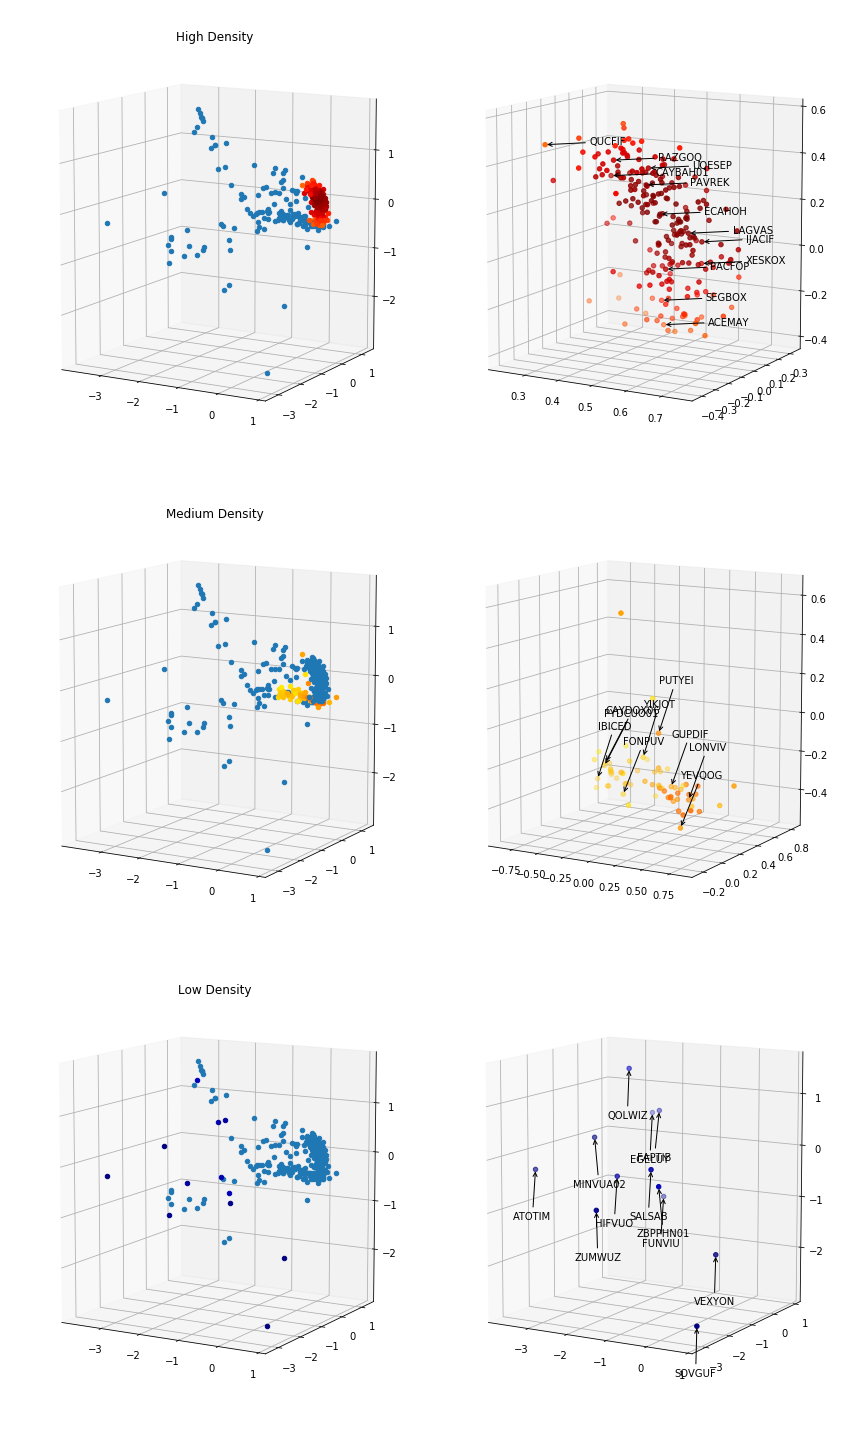

In [41]:
duration = 10
cpd_c = 0
clrmp = mpl.cm.get_cmap('jet')

clrr = []
for ptpos in prj_unfld:
    clrr.append(krnl(ptpos)[0])
clrnorm = mpl.colors.LogNorm(min(clrr), max(clrr))

fig4 = plt.figure(figsize=(12,20))
for ss, pp in zip(product('123', '1'), [1,3,5]):
    exec('ax4'+''.join(ss)+ '= fig4.add_subplot(32'+str(pp)+", projection='3d')")
# ax4.scatter(*prj_unfld.T[0:3], c=clrmp(clrnorm(clrr)))
    exec("ax4"+''.join(ss)+".view_init(10,)")

###############################
hi_dns_pt = []
hi_dns_lb = []
hi_dns_ds = []
for ptpos, dsty, lb_tmp in zip(prj_unfld, clrr, btlnk_ld.index.values.tolist()):
    if dsty >.4:
        ax411.scatter(*ptpos, c=clrmp(clrnorm(dsty)))
        hi_dns_pt.append(ptpos)
        hi_dns_lb.append(lb_tmp)
        hi_dns_ds.append(dsty)
    elif dsty <=.4:
        ax411.scatter(*ptpos, c='C0')
ax411.set_title('High Density')

ax412 = fig4.add_subplot(322, projection='3d')
# ax2.scatter(*prj_unfld[np.array(min_dist)<.5].T)
# ax2.scatter(*np.array(med_dns_pt).T)
ax412.scatter(*np.array(hi_dns_pt).T, c=clrmp(clrnorm(hi_dns_ds)))
ax412.view_init(10)

pca = PCA(n_components=2)
hidens_pca = pca.fit_transform(np.array(hi_dns_pt))
# plt.scatter(*hidens_pca.T)
# hi_dens_idsrt = hi_dens_id[np.argsort(hidens_pca.T[0])]
hidenspc1 = hidens_pca.T[0]
hidenspc1argst = hidenspc1.argsort()
hidens_sel = hidenspc1argst[::20]

for pthilt in range(len(hidens_sel)):
    xano2, yano2, _ = proj3d.proj_transform(*hi_dns_pt[hidens_sel[pthilt]], ax412.get_proj())
    ax412.annotate(hi_dns_lb[hidens_sel[pthilt]], xy=(xano2, yano2), xytext=(xano2+.02, yano2),
                arrowprops=dict(arrowstyle='->'))
    
###############################
med_dns_pt = []
med_dns_lb = []
med_dns_ds = []
for ptpos, dsty, lb_tmp in zip(prj_unfld, clrr, btlnk_ld.index.values.tolist()):
    if .2 < dsty <.4:
        ax421.scatter(*ptpos, c=clrmp(clrnorm(dsty)))
        med_dns_pt.append(ptpos)
        med_dns_lb.append(lb_tmp)
        med_dns_ds.append(dsty)
#     elif dsty <=.4:
    else:
        ax421.scatter(*ptpos, c='C0')
ax421.set_title('Medium Density')

ax422 = fig4.add_subplot(324, projection='3d')
ax422.scatter(*np.array(med_dns_pt).T, c=clrmp(clrnorm(med_dns_ds)))
ax422.view_init(10)

pca = PCA(n_components=2)
meddens_pca = pca.fit_transform(np.array(med_dns_pt))
meddenspc1 = meddens_pca.T[0]
meddenspc1argst = meddenspc1.argsort()
meddens_sel = meddenspc1argst[::8]

for pthilt in range(len(meddens_sel)):
    xano2, yano2, _ = proj3d.proj_transform(*med_dns_pt[meddens_sel[pthilt]], ax422.get_proj())
    ax422.annotate(med_dns_lb[meddens_sel[pthilt]], xy=(xano2, yano2), xytext=(xano2, yano2+.02),
                arrowprops=dict(arrowstyle='->'))
    
###############################
lo_dns_pt = []
lo_dns_lb = []
lo_dns_ds = []
for ptpos, dsty, lb_tmp in zip(prj_unfld, clrr, btlnk_ld.index.values.tolist()):
    if dsty <=.012:
        ax431.scatter(*ptpos, c=clrmp(clrnorm(dsty)))
        lo_dns_pt.append(ptpos)
        lo_dns_lb.append(lb_tmp)
        lo_dns_ds.append(dsty)
#     elif dsty <=.4:
    else:
        ax431.scatter(*ptpos, c='C0')
ax431.set_title('Low Density')

ax432 = fig4.add_subplot(326, projection='3d')
ax432.scatter(*np.array(lo_dns_pt).T, c=clrmp(clrnorm(lo_dns_ds)))
ax432.view_init(10)

for pthilt in range(len(lo_dns_pt)):
    xano2, yano2, _ = proj3d.proj_transform(*lo_dns_pt[pthilt], ax432.get_proj())
    ax432.annotate(lo_dns_lb[pthilt], xy=(xano2, yano2), xytext=(xano2-.01, yano2-.02),
                arrowprops=dict(arrowstyle='->'))
    
fig4.tight_layout()
fig4.savefig('./'+bcd_dist[bcd_dist_sel]+'_isomap_alt'+str(10)+surf_ppt[surf_ppt_sel]+'_dsty.pdf', bbox_inches='tight')

In [43]:
# df=
print(\
pd.DataFrame([[hi_dns_lb[hidens_sel[pthilt]] for pthilt in range(len(hidens_sel))],
              [med_dns_lb[meddens_sel[pthilt]] for pthilt in range(len(meddens_sel))], 
              lo_dns_lb], index=['hi', 'med', 'lo']).T.to_latex()
     )

\begin{tabular}{llll}
\toprule
{} &        hi &       med &        lo \\
\midrule
0  &    QUCFIF &  CAYDOX06 &    FUNVIU \\
1  &    RAZGOQ &    IBICED &    ATOTIM \\
2  &    UQESEP &  PYDCUO01 &    VEXYON \\
3  &    PAVREK &    FONPUV &    QOLWIZ \\
4  &  CAYBAH01 &    YIKJOT &    HIFVUO \\
5  &    ECAHOH &    GUPDIF &    SOVGUF \\
6  &    LAGVAS &    PUTYEI &  ZBPPHN01 \\
7  &    IJACIF &    LONVIV &    EGELUY \\
8  &    PACFOP &    YEVQOG &    SALSAB \\
9  &    XESKOX &      None &  MINVUA02 \\
10 &    SEGBOX &      None &    FAPTIB \\
11 &    ACEMAY &      None &    ZUMWUZ \\
\bottomrule
\end{tabular}



In [24]:
df.to_latex

<bound method NDFrame.to_latex of           hi       med        lo
0     QUCFIF  CAYDOX06    FUNVIU
1     RAZGOQ    IBICED    ATOTIM
2     UQESEP  PYDCUO01    VEXYON
3     PAVREK    FONPUV    QOLWIZ
4   CAYBAH01    YIKJOT    HIFVUO
5     ECAHOH    GUPDIF    SOVGUF
6     LAGVAS    PUTYEI  ZBPPHN01
7     IJACIF    LONVIV    EGELUY
8     PACFOP    YEVQOG    SALSAB
9     XESKOX      None  MINVUA02
10    SEGBOX      None    FAPTIB
11    ACEMAY      None    ZUMWUZ>

In [96]:
df.dropna(axis=1, inplace=True)

In [109]:
len(btlnk_ld.index.values)

392